## Model trained on Transistor dataset with results. 

A little bit better results than in Transistor.ipynb. Works fine, but also have some mistakes. Images are scailed on 128x128.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode="unmodified"):
        super().__init__()
        assert mode in ["unmodified", "upsample", "downsample"]
        self.mode = mode
        if mode == "unmodified":
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.ReLU()
            )
        elif mode == "upsample":
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU()
            )
        elif mode == "downsample":
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2),
                nn.ReLU()
            )

        self.id = nn.Identity()

        if in_channels != out_channels or mode == "downsample":
            self.id = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if mode == "downsample" else 1),
            )
        elif mode == "upsample":
            self.id = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        main_path_out = self.block(x)
        shortcut_out = self.id(x)
        if main_path_out.shape != shortcut_out.shape:
            shortcut_out = F.interpolate(shortcut_out, size=main_path_out.shape[2:], mode='nearest')
        return main_path_out + shortcut_out


class ResNetEncoder(nn.Module):
    def __init__(self, in_channels, latent_dim, block_name="ResidualBlock", **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.create_network(latent_dim)

    def create_network(self, latent_dim):
        self.input_net = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.body_net = nn.Sequential(
            ResidualBlock(in_channels=32, out_channels=64, mode="downsample"),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=128, mode="downsample"),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=256, mode="downsample"),
            ResidualBlock(in_channels=256, out_channels=256),
            ResidualBlock(in_channels=256, out_channels=256)
        )

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),  # Pool to 8x8
            nn.Flatten(),
            nn.Linear(256*8*8, latent_dim)  # Match the pooled size
        )

    def forward(self, x):
        # print(f"Encoder input shape: {x.shape}")
        x = self.input_net(x)
        x = self.body_net(x)
        # print(f"Shape after body_net: {x.shape}")
        x = self.output_net(x)
        # print(f"Encoder output shape: {x.shape}")
        return x




class ResNetDecoder(nn.Module):
    def __init__(self, out_channels, latent_dim, block_name="ResidualBlock", **kwargs):
        super().__init__()
        self.out_channels = out_channels
        self.create_network(latent_dim)

    def create_network(self, latent_dim):
        self.inverse_output_net = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),  # Match the encoder output
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(256, 8, 8))
        )

        self.inverse_body_net = nn.Sequential(
            ResidualBlock(in_channels=256, out_channels=128, mode="upsample"),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=64, mode="upsample"),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=32, mode="upsample"),
            ResidualBlock(in_channels=32, out_channels=32),
            ResidualBlock(in_channels=32, out_channels=32)
        )

        self.inverse_input_net = nn.Sequential(
            nn.ConvTranspose2d(32, self.out_channels, kernel_size=4, stride=2, padding=1),  # Ensure correct upsampling
            nn.Tanh()
        )

    def forward(self, x):
        # print(f"Decoder input shape: {x.shape}")
        x = self.inverse_output_net(x)
        # print(f"Shape after inverse_output_net: {x.shape}")
        x = self.inverse_body_net(x)
        # print(f"Shape after inverse_body_net: {x.shape}")
        x = self.inverse_input_net(x)
        # print(f"Decoder output shape: {x.shape}")
        return x


class Autoencoder(pl.LightningModule):
    def __init__(self, latent_dim, encoder_class=ResNetEncoder, decoder_class=ResNetDecoder, num_input_channels=3, width=128, height=128):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = encoder_class(num_input_channels, latent_dim)
        self.decoder = decoder_class(num_input_channels, latent_dim)

    def forward(self, x):
        # print(f"Autoencoder input shape: {x.shape}")
        z = self.encoder(x)
        x_hat = self.decoder(z)
        # print(f"Autoencoder output shape: {x_hat.shape}")
        return x_hat

    def _get_reconstruction_loss(self, batch):
        x, _ = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)



# Dataset and DataLoader definition
class TransistorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path
    
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = TransistorDataset(root_dir='./archive/transistor/train/good', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TransistorDataset(root_dir='./archive/transistor/test/good', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TransistorDataset(root_dir='./archive/transistor/test/bent_lead', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)



# Training the model
lr_monitor = LearningRateMonitor(logging_interval='epoch')

model = Autoencoder(latent_dim=256).to('mps')

# Training setup
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='transistor_model2-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)
trainer = pl.Trainer(max_epochs=50, callbacks=[checkpoint_callback, lr_monitor], accelerator='mps')

# Train the model
trainer.fit(model, train_loader, val_loader)

# Manually save the model
torch.save(model.state_dict(), 'transistor_model2.pth')

# Loading the model
loaded_model = Autoencoder(latent_dim=256).to('mps')
loaded_model.load_state_dict(torch.load('transistor_model2.pth'))
loaded_model.eval()




GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | encoder | ResNetEncoder | 6.2 M  | train
1 | decoder | ResNetDecoder | 5.3 M  | train
--------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.028    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/nr/yzg_nf3s5zld2lpjkmg7svv80000gn/T/ipykernel_6100/86284622.py:154: UserWarning: Using a target size (torch.Size([32, 3, 128, 128])) that is different to the input size (torch.Size([32, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x, x_hat, reduction="none")


RuntimeError: The size of tensor a (256) must match the size of tensor b (128) at non-singleton dimension 3

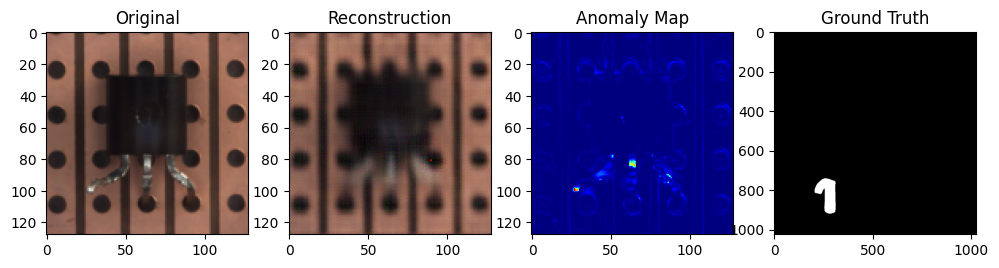

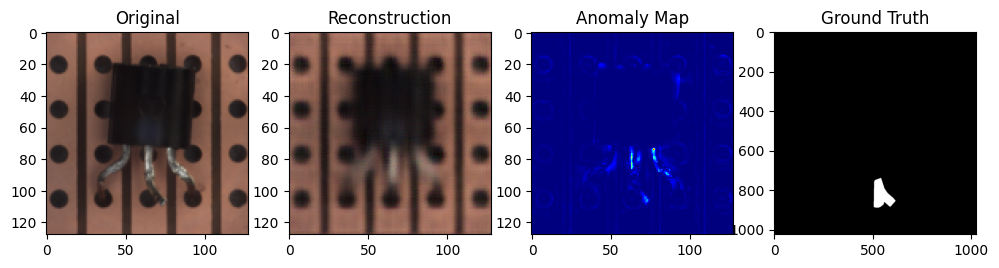

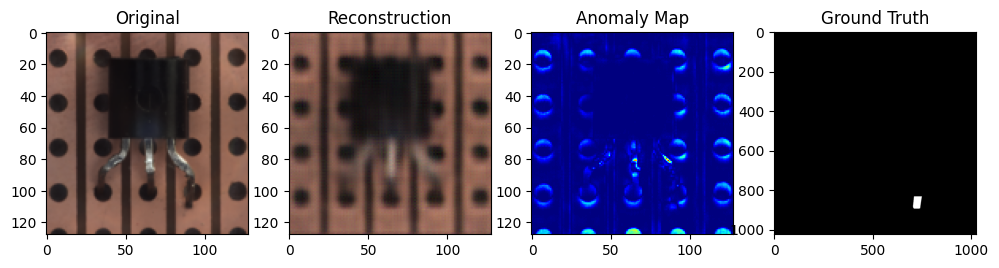

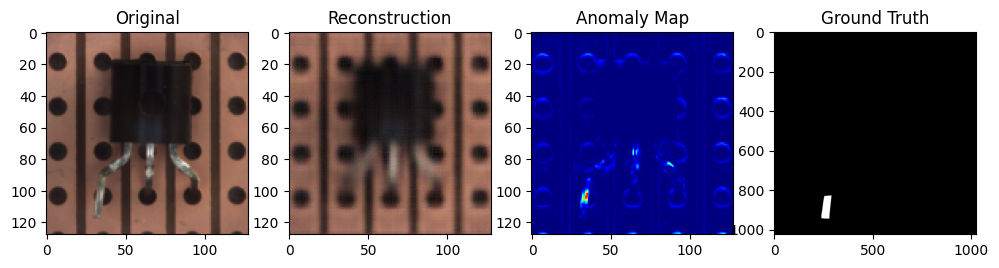

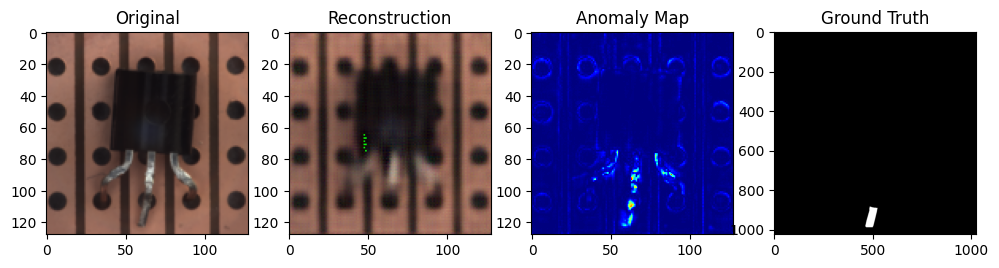

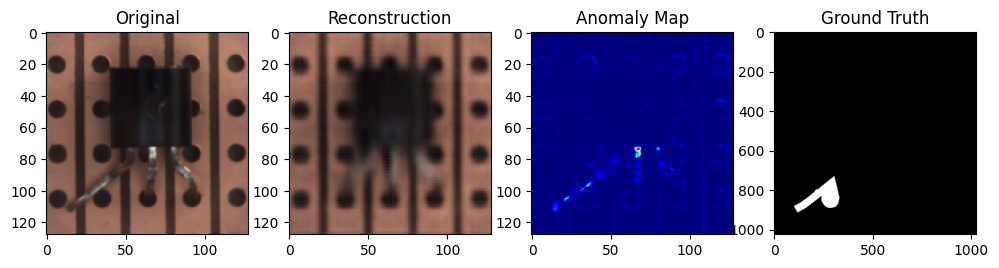

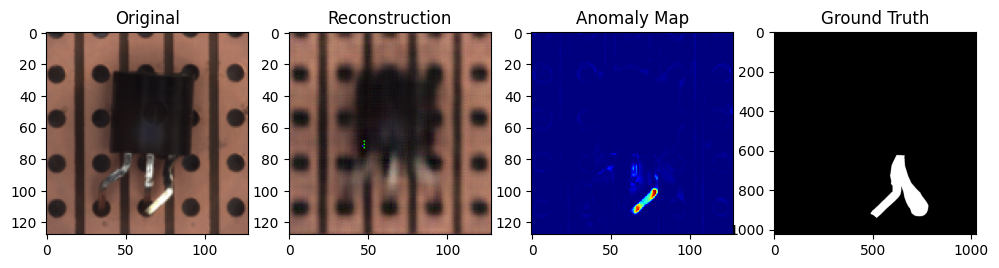

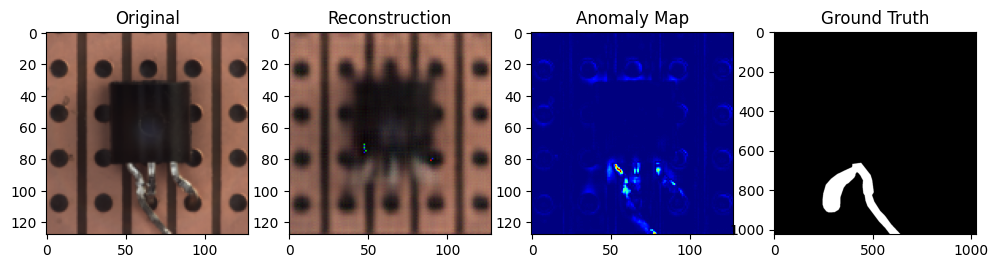

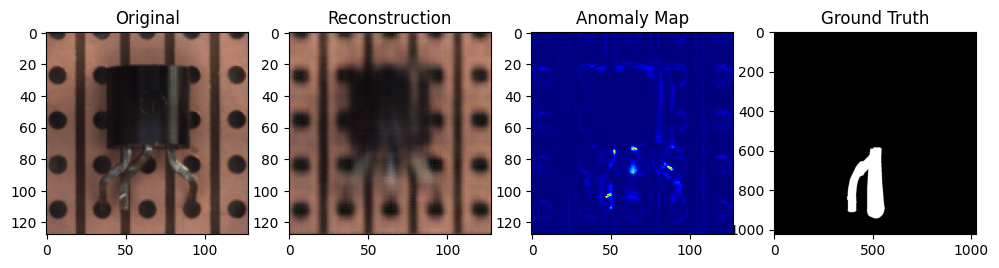

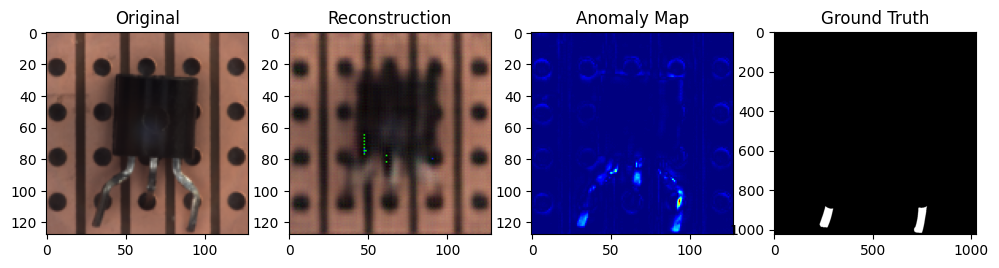

In [3]:

# Testiranje modela i detekcija anomalija
def detect_anomalies(model, test_loader, ground_truth_dir):
    model.eval()
    anomaly_scores = []
    with torch.no_grad():
        for batch, img_paths in test_loader:
            batch = batch.to('mps')
            reconstructions = model(batch)
            loss = F.mse_loss(batch, reconstructions, reduction='none')
            loss = loss.sum(dim=[1, 2, 3]).cpu().numpy()
            anomaly_scores.extend(loss)

            for i, img_path in enumerate(img_paths):
                original_img = transforms.ToPILImage()(batch[i].cpu())
                reconstructed_img = transforms.ToPILImage()(reconstructions[i].cpu())
                
                img_name = os.path.basename(img_path)
                name, ext = os.path.splitext(img_name)
                img_name = f"{name}_mask{ext}"

                ground_truth_path = os.path.join(ground_truth_dir, img_name)
                ground_truth_img = Image.open(ground_truth_path).convert("L") if os.path.exists(ground_truth_path) else None

                anomaly_map = torch.mean((batch[i] - reconstructions[i]) ** 2, dim=0)
                anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())
                anomaly_map = anomaly_map.cpu().numpy()

                fig, axs = plt.subplots(1, 4, figsize=(12, 3))
                axs[0].imshow(original_img)
                axs[0].set_title("Original")
                axs[1].imshow(reconstructed_img)
                axs[1].set_title("Reconstruction")
                axs[2].imshow(anomaly_map, cmap='jet')
                axs[2].set_title("Anomaly Map")
                if ground_truth_img:
                    axs[3].imshow(ground_truth_img, cmap='gray')
                    axs[3].set_title("Ground Truth")
                else:
                    axs[3].axis('off')
                plt.show()
    return anomaly_scores

ground_truth_dir = './archive/transistor/ground_truth/bent_lead'
anomaly_scores = detect_anomalies(loaded_model, test_loader, ground_truth_dir)

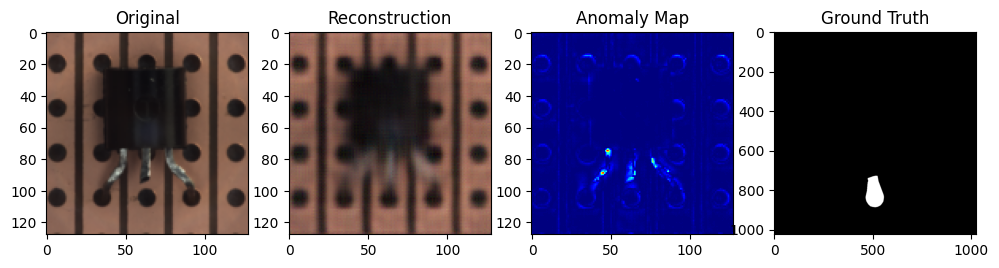

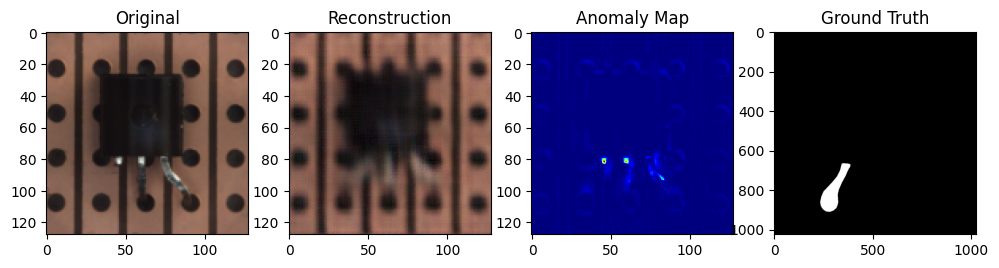

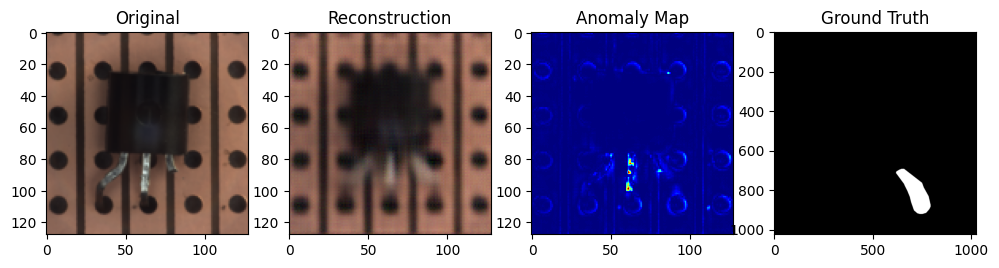

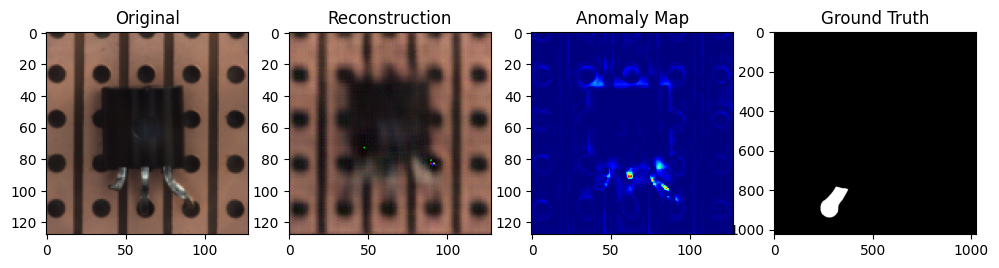

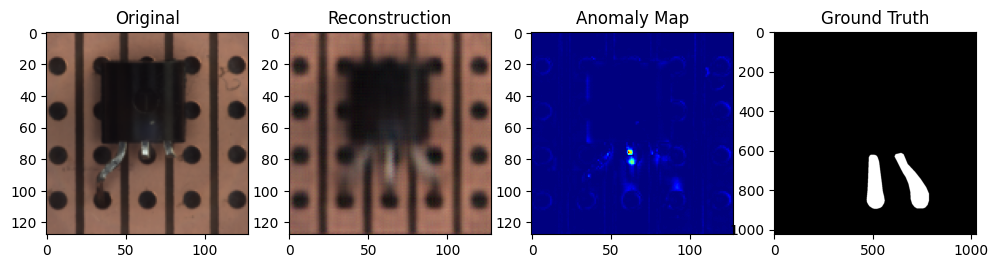

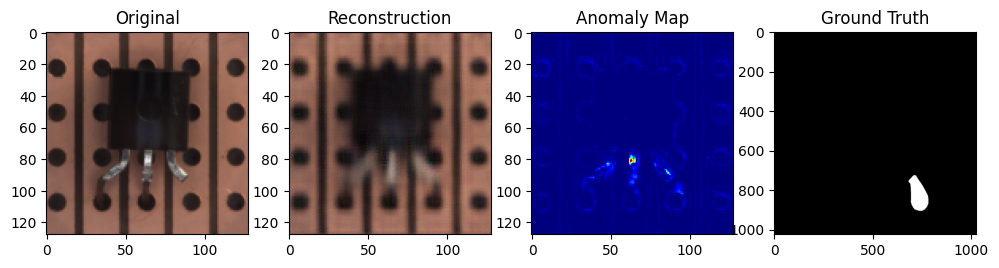

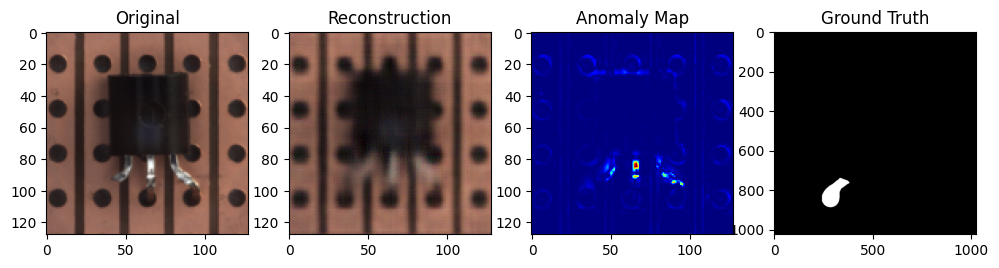

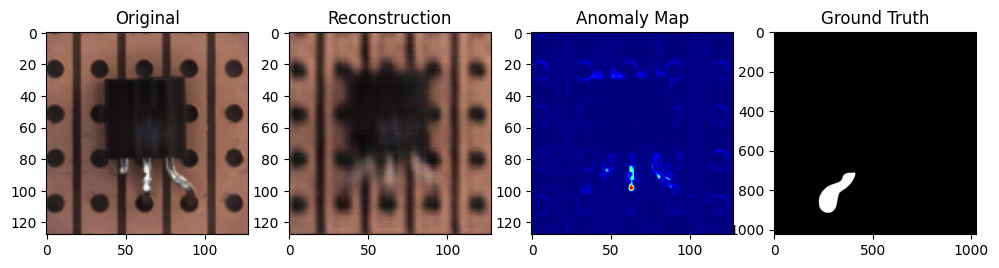

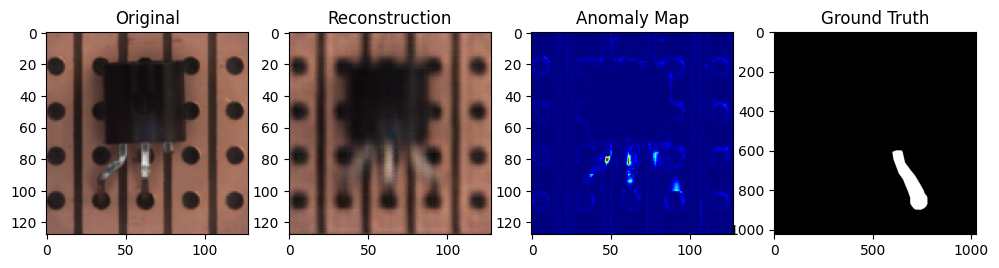

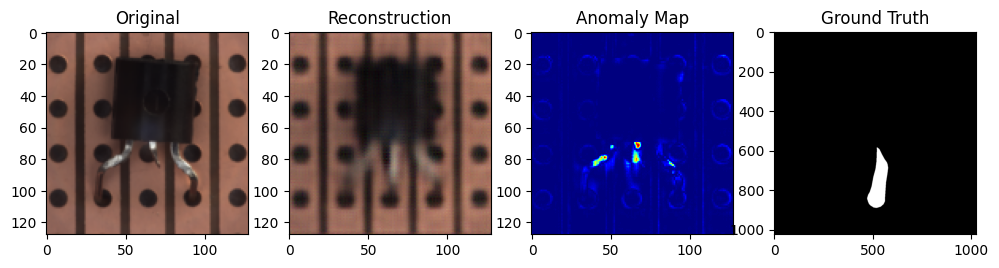

In [4]:
test_dataset = TransistorDataset(root_dir='./archive/transistor/test/cut_lead', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

ground_truth_dir = './archive/transistor/ground_truth/cut_lead'
anomaly_scores = detect_anomalies(loaded_model, test_loader, ground_truth_dir)

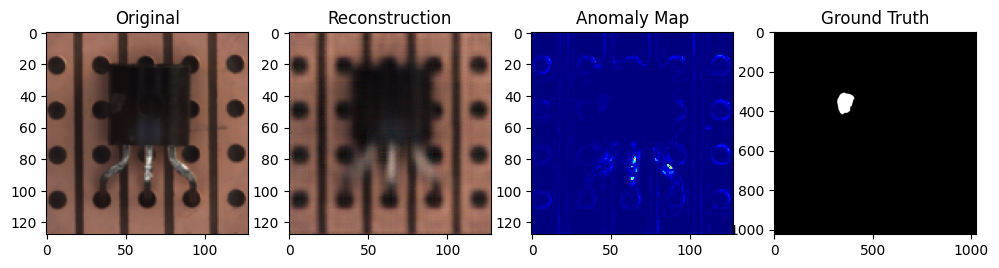

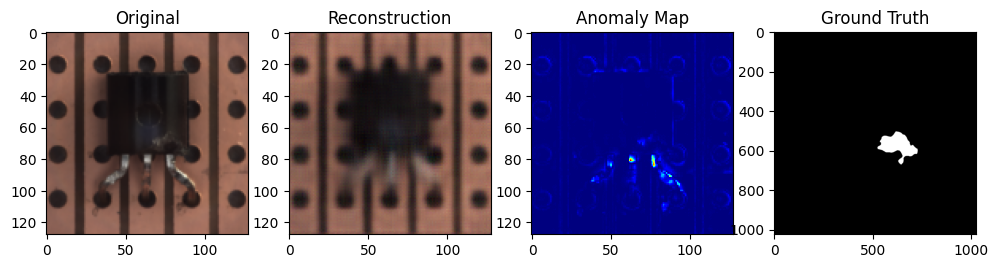

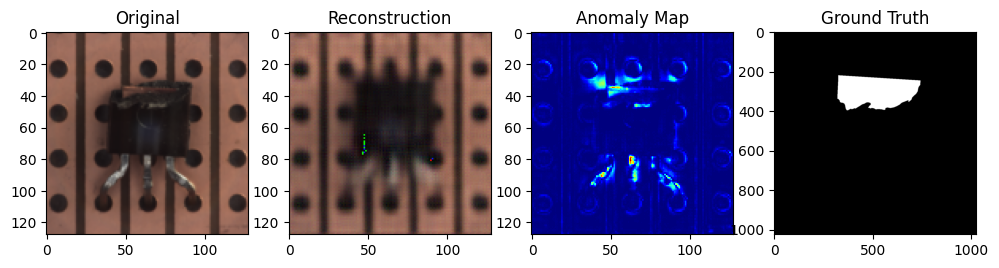

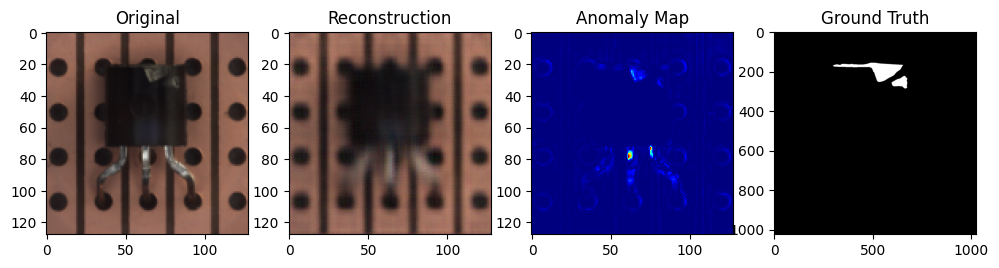

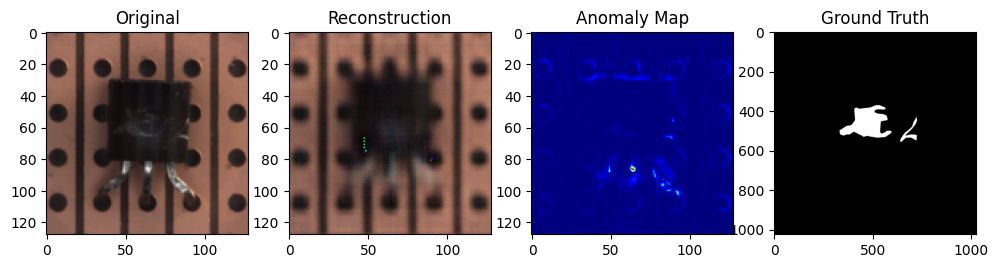

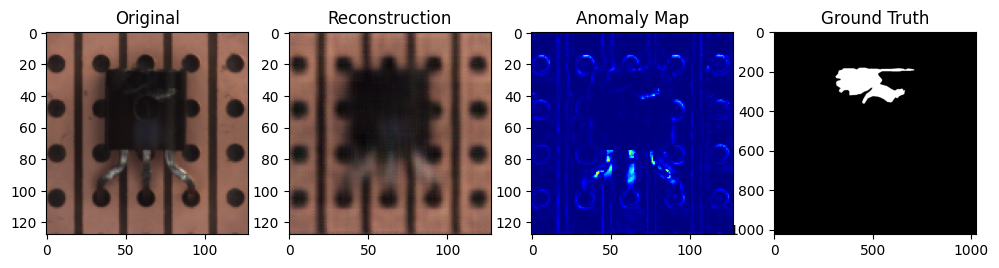

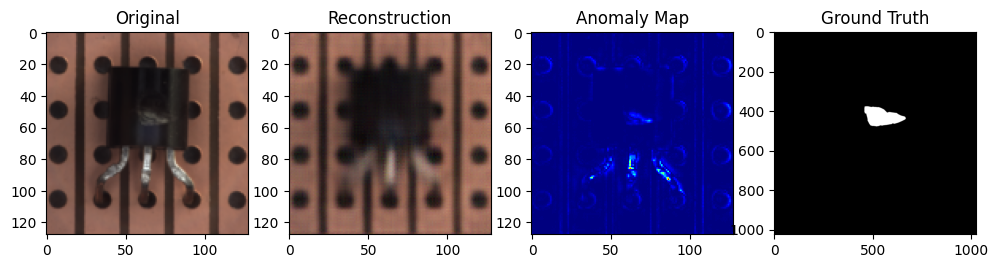

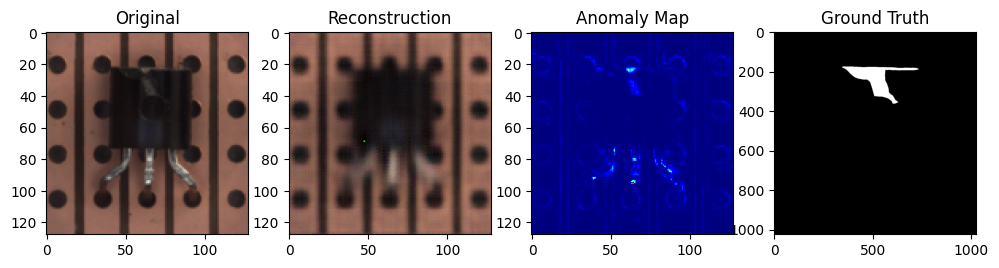

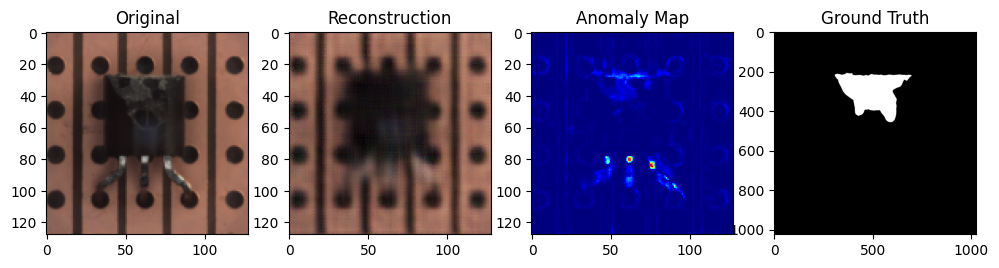

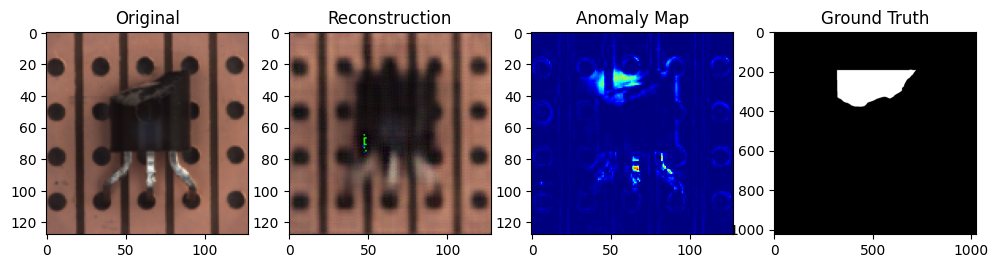

In [5]:
test_dataset = TransistorDataset(root_dir='./archive/transistor/test/damaged_case', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

ground_truth_dir = './archive/transistor/ground_truth/damaged_case'
anomaly_scores = detect_anomalies(loaded_model, test_loader, ground_truth_dir)

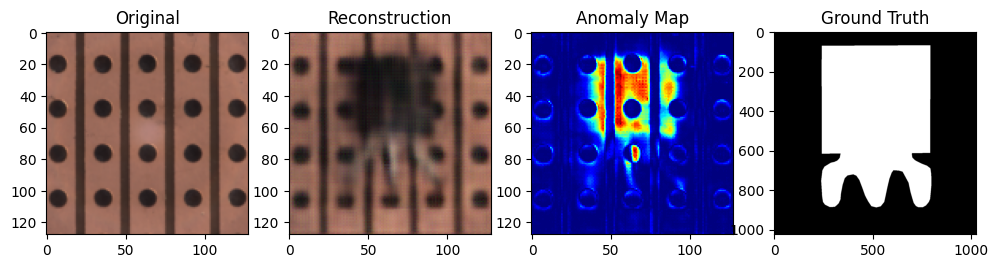

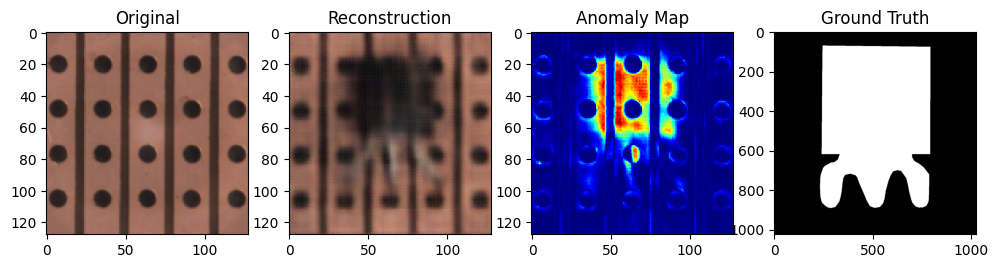

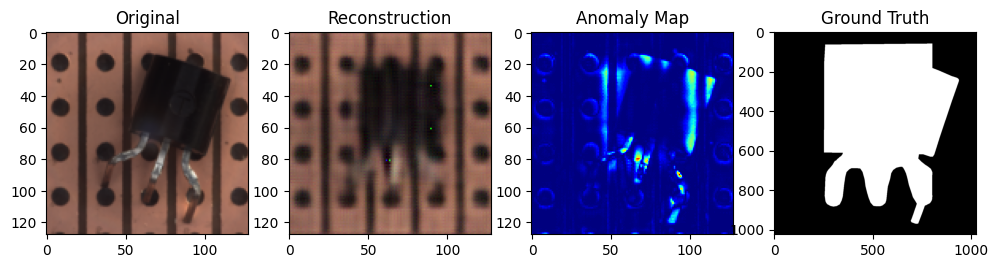

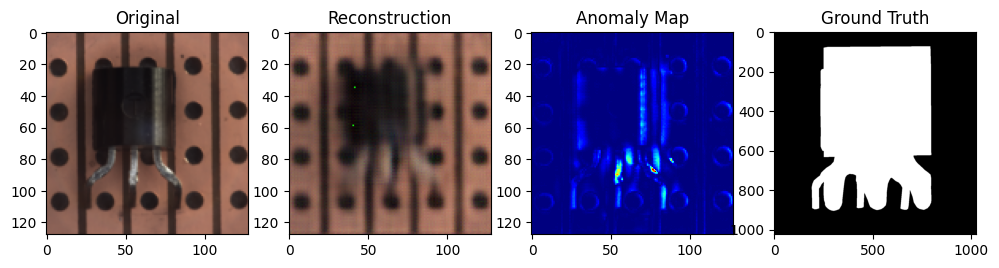

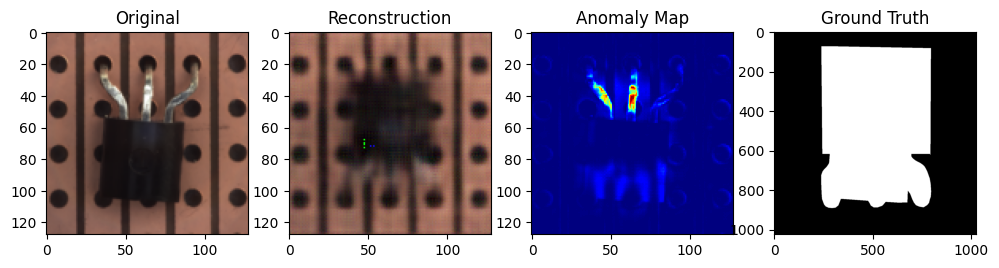

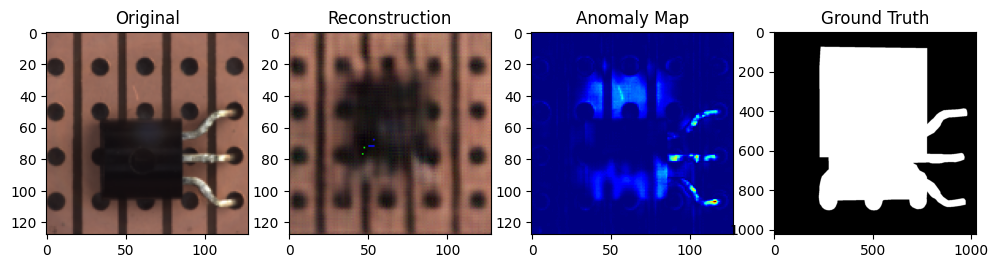

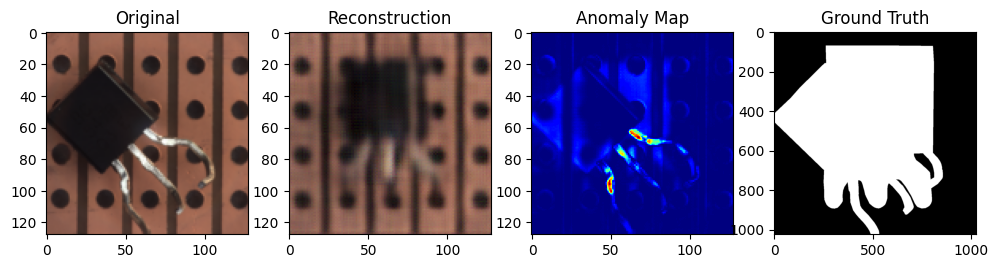

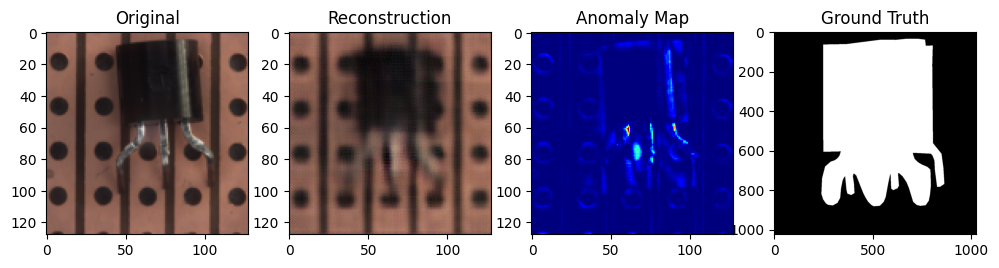

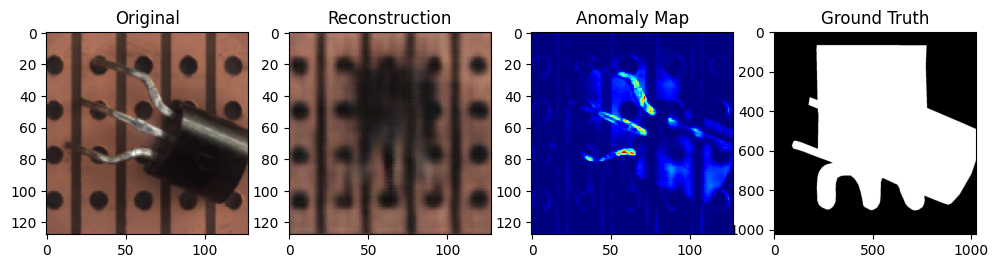

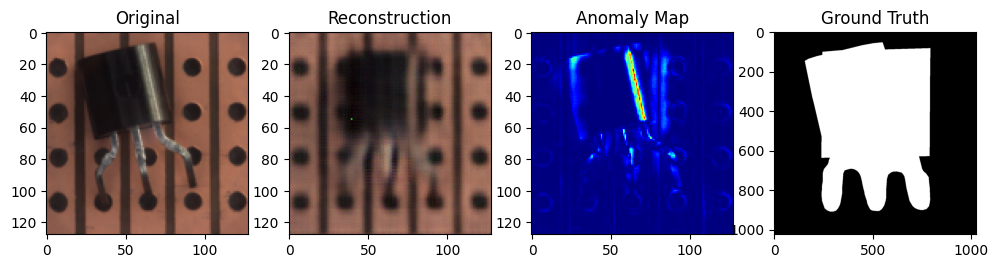

In [6]:
test_dataset = TransistorDataset(root_dir='./archive/transistor/test/misplaced', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

ground_truth_dir = './archive/transistor/ground_truth/misplaced'
anomaly_scores = detect_anomalies(loaded_model, test_loader, ground_truth_dir)